# visualization of  Caffe furtures

## First, import required modules, set plotting parameters

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/export/wangqingze/caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## In this example we will store a copy of all the plots at every stage, so we define the storing function here

In [38]:
import time

def export_plot(fig,filename,path='',format='pdf',date=True):
    """
    Exports the figure into the project folder
    suported formats : eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    if date:
        formated_filename = os.path.join(path, "{0}{1}.{2}".format(time.strftime("%Y%m%d_%H%M%S"), filename, format))
    else:
        formated_filename = os.path.join(path,"{0}.{1}".format(filename, format))
    fig.savefig(formated_filename, format=format)

## Set Caffe to GPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [39]:
caffe.set_device(1)
caffe.set_mode_gpu()
net = caffe.Net('/export/wangqingze/caffe/examples/cnn_ocr/short_deploy.prototxt',
             '/export/wangqingze/caffe/examples/cnn_ocr/short_iter_40000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

## Here we print a summary of the network's architecture

In [40]:
model_name = 'ocr'

def network_summary(net):
    """
    Returns a string with a summary of the specified network
    """
    string = "Architecture of {} network\n---------------------".format(model_name)
    for layer in net.layers:
        string += "\n" + layer.type

    string += "\n\nFeature map sizes (Blobs)\n-------------------------"
    for layer in net.blobs.keys():
        string += "\n{} = \t{}".format(layer, net.blobs[layer].data.shape)

    string += "\n\nParameter shape\n---------------"
    for layer in net.params.keys():
        string += "\n{} = {} \t(min,max) = ({:.2f},{:.2f})".format(
                layer, net.params[layer][0].data.shape,
                net.params[layer][0].data.min(), 
                net.params[layer][0].data.max())
    string += "\n"
    return string


print network_summary(net)


Architecture of ocr network
---------------------
Input
Convolution
Pooling
ReLU
Split
Convolution
Pooling
ReLU
Reshape
Convolution
Pooling
ReLU
Reshape
Concat
Convolution
Split
ReLU
InnerProduct
Softmax

Feature map sizes (Blobs)
-------------------------
data = 	(1, 3, 32, 32)
conv1 = 	(1, 32, 32, 32)
pool1 = 	(1, 32, 16, 16)
relu1 = 	(1, 32, 16, 16)
relu1_relu1_0_split_0 = 	(1, 32, 16, 16)
relu1_relu1_0_split_1 = 	(1, 32, 16, 16)
conv2 = 	(1, 64, 16, 14)
pool2 = 	(1, 64, 8, 7)
relu2 = 	(1, 64, 8, 7)
reshape1 = 	(1, 64, 56)
conv3 = 	(1, 64, 14, 16)
pool3 = 	(1, 64, 7, 8)
relu3 = 	(1, 64, 7, 8)
reshape2 = 	(1, 64, 56)
concat = 	(1, 128, 56)
conv4 = 	(1, 1, 56)
conv4_conv4_0_split_0 = 	(1, 1, 56)
conv4_conv4_0_split_1 = 	(1, 1, 56)
relu4 = 	(1, 1, 56)
ip1 = 	(1, 3816)
prob = 	(1, 3816)

Parameter shape
---------------
conv1 = (32, 3, 3, 3) 	(min,max) = (-1.34,1.22)
conv2 = (64, 32, 3, 5) 	(min,max) = (-0.82,0.45)
conv3 = (64, 32, 5, 3) 	(min,max) = (-0.25,0.23)
conv4 = (1, 128, 1) 	(mi

## We can visualize all the weights of the network

In [41]:
layer_map = {}
ind = 0
for layer_name in net._layer_names:
    layer_map[layer_name] = ind
    ind +=1

print layer_map

{'reshape2': 12, 'conv4_conv4_0_split': 15, 'relu3': 11, 'relu2': 7, 'relu1': 3, 'relu4': 16, 'conv3': 9, 'conv2': 5, 'conv1': 1, 'reshape1': 8, 'ip1': 17, 'relu1_relu1_0_split': 4, 'conv4': 14, 'pool3': 10, 'pool2': 6, 'pool1': 2, 'data': 0, 'prob': 18, 'concat': 13}


In [42]:
from math import ceil

def vis_square(data, padsize = 1, padval = 0):
    '''take an array of shape (n, height, width) or (n, height, width, channels)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    '''
    filt_min, filt_max = data.min(), data.max()
    if data.ndim < 3:
        shape = data.shape + (3 - data.ndim) * ((1),)
        data = data.reshape(shape)

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data, vmin=filt_min, vmax=filt_max, cmap=plt.cm.gray)
    plt.axis('off')
    
    
import time

def export_plot(fig,filename,path='',format='pdf',date=True):
    """
    Exports the figure into the project folder
    suported formats : eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    if date:
        formated_filename = os.path.join(path, "{0}{1}.{2}".format(time.strftime("%Y%m%d_%H%M%S"), filename, format))
    else:
        formated_filename = os.path.join(path,"{0}.{1}".format(filename, format))
    fig.savefig(formated_filename, format=format)

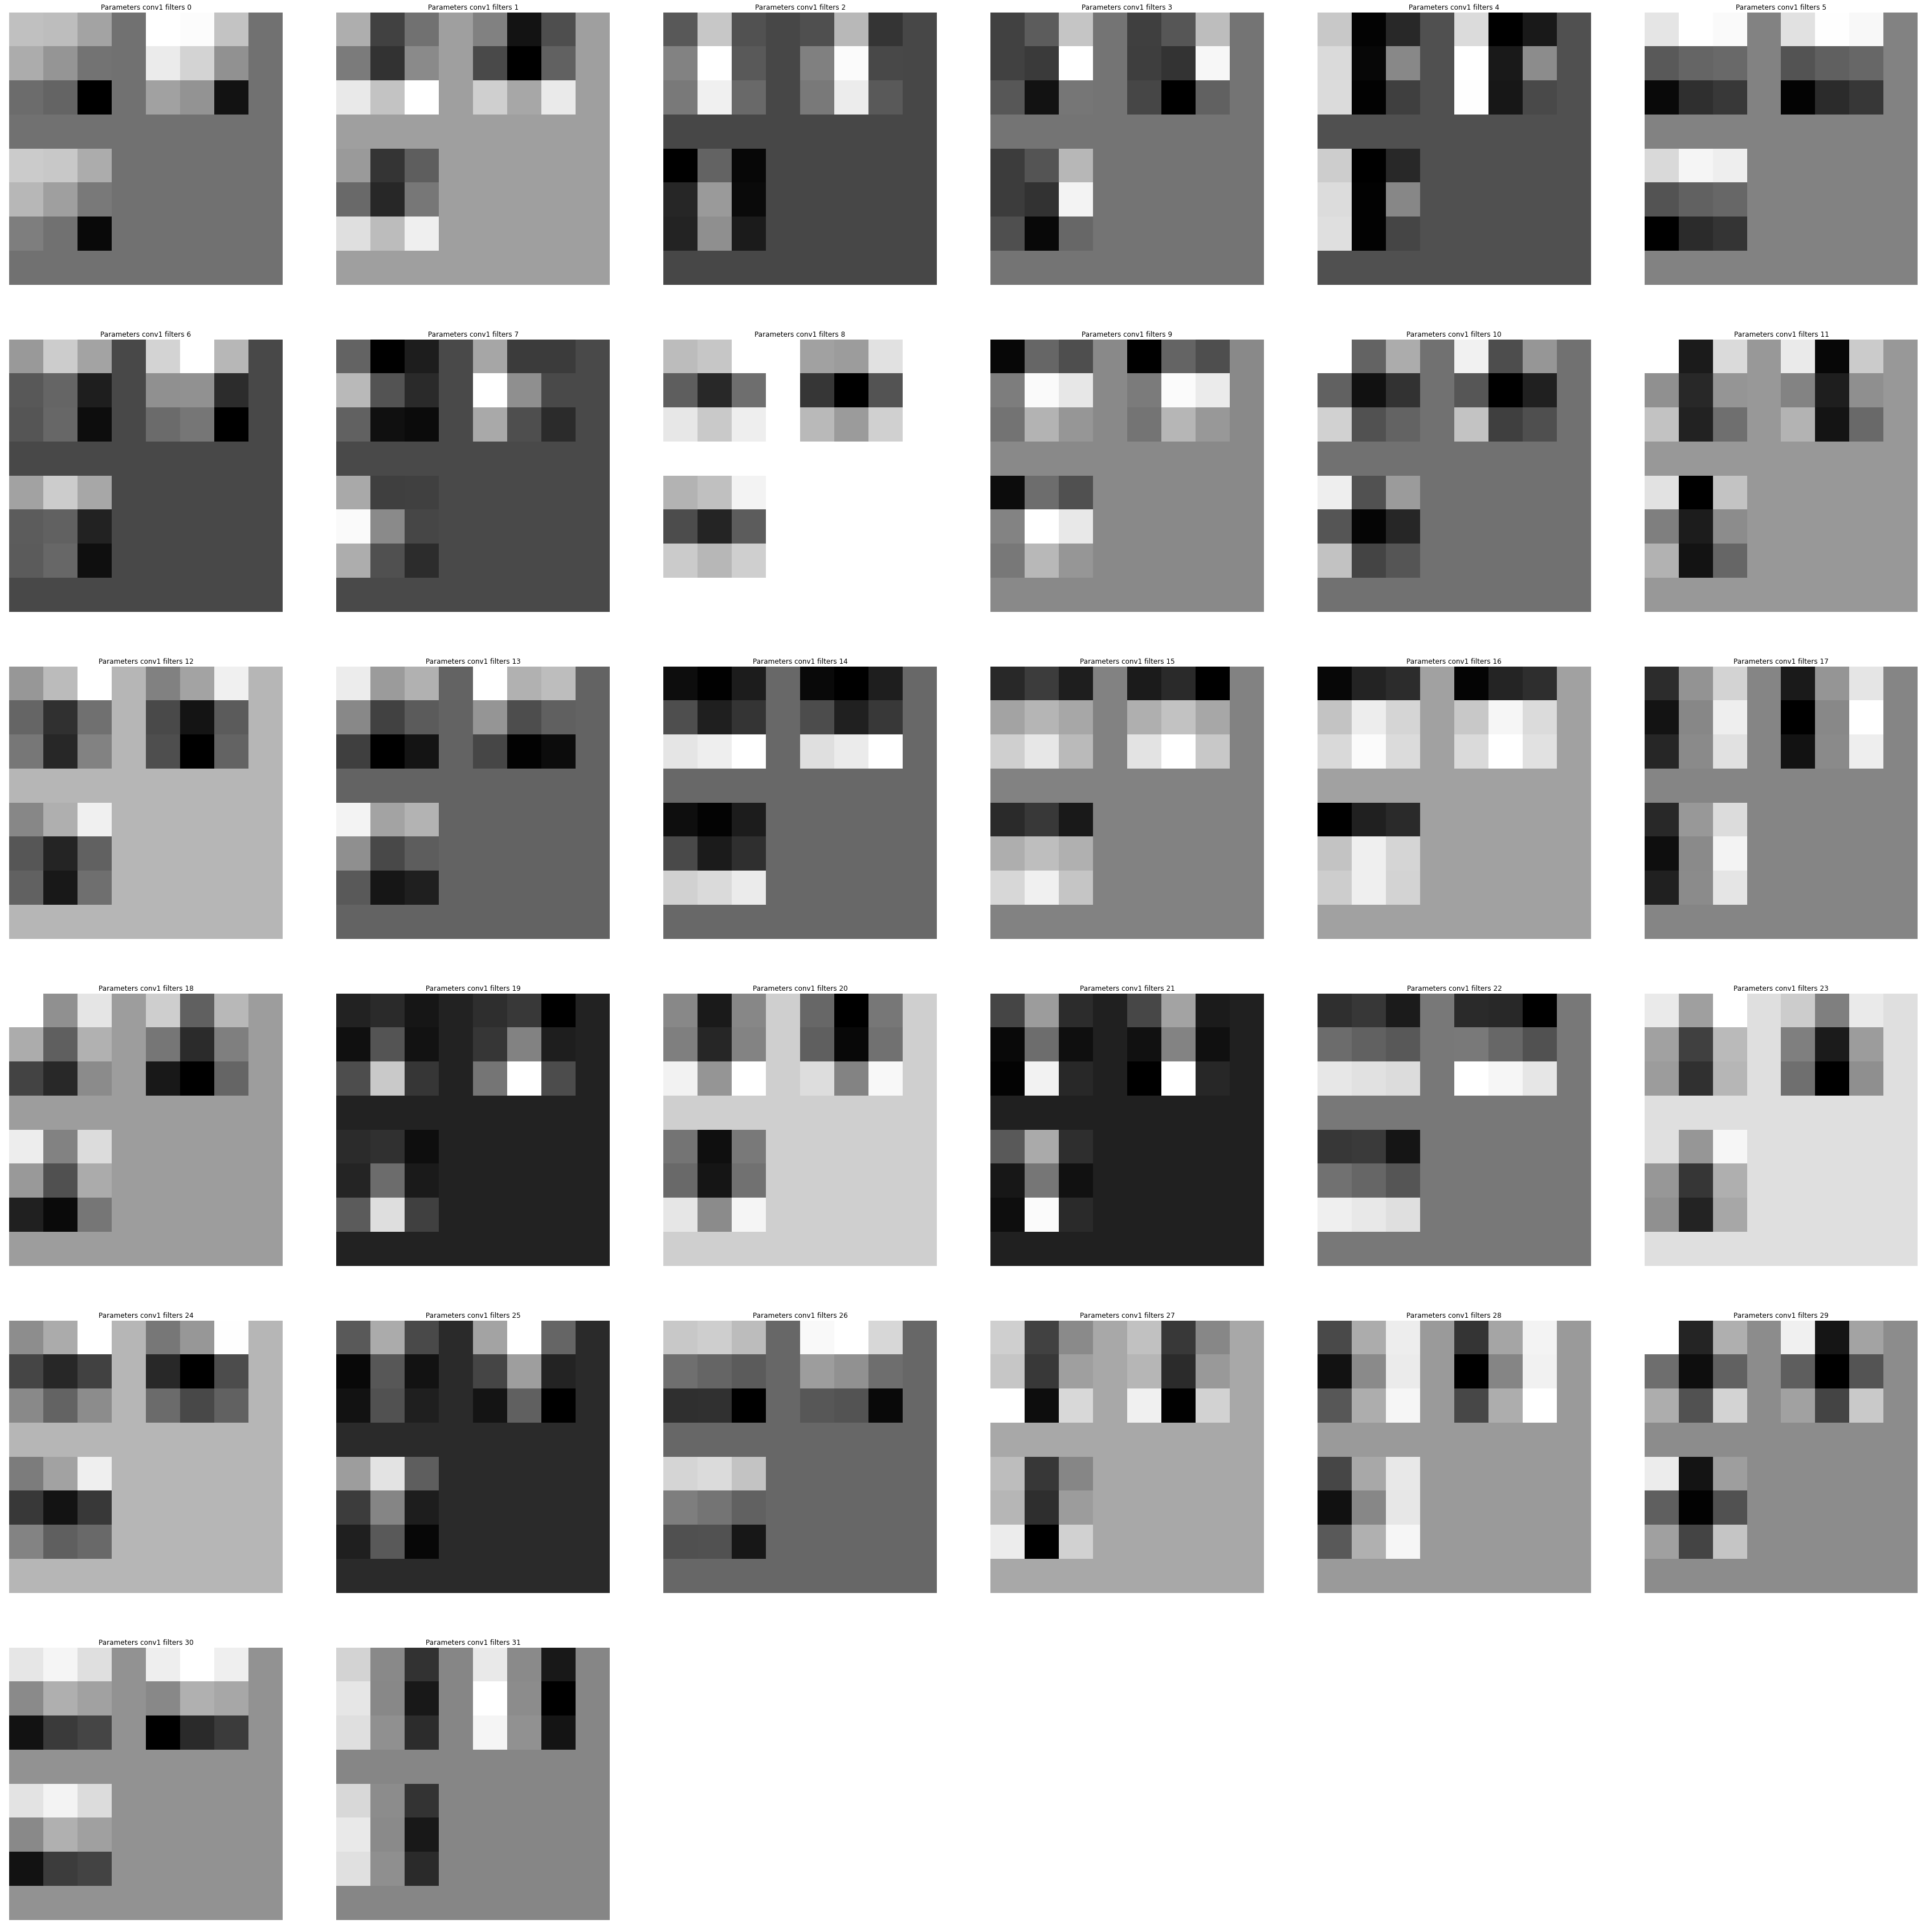

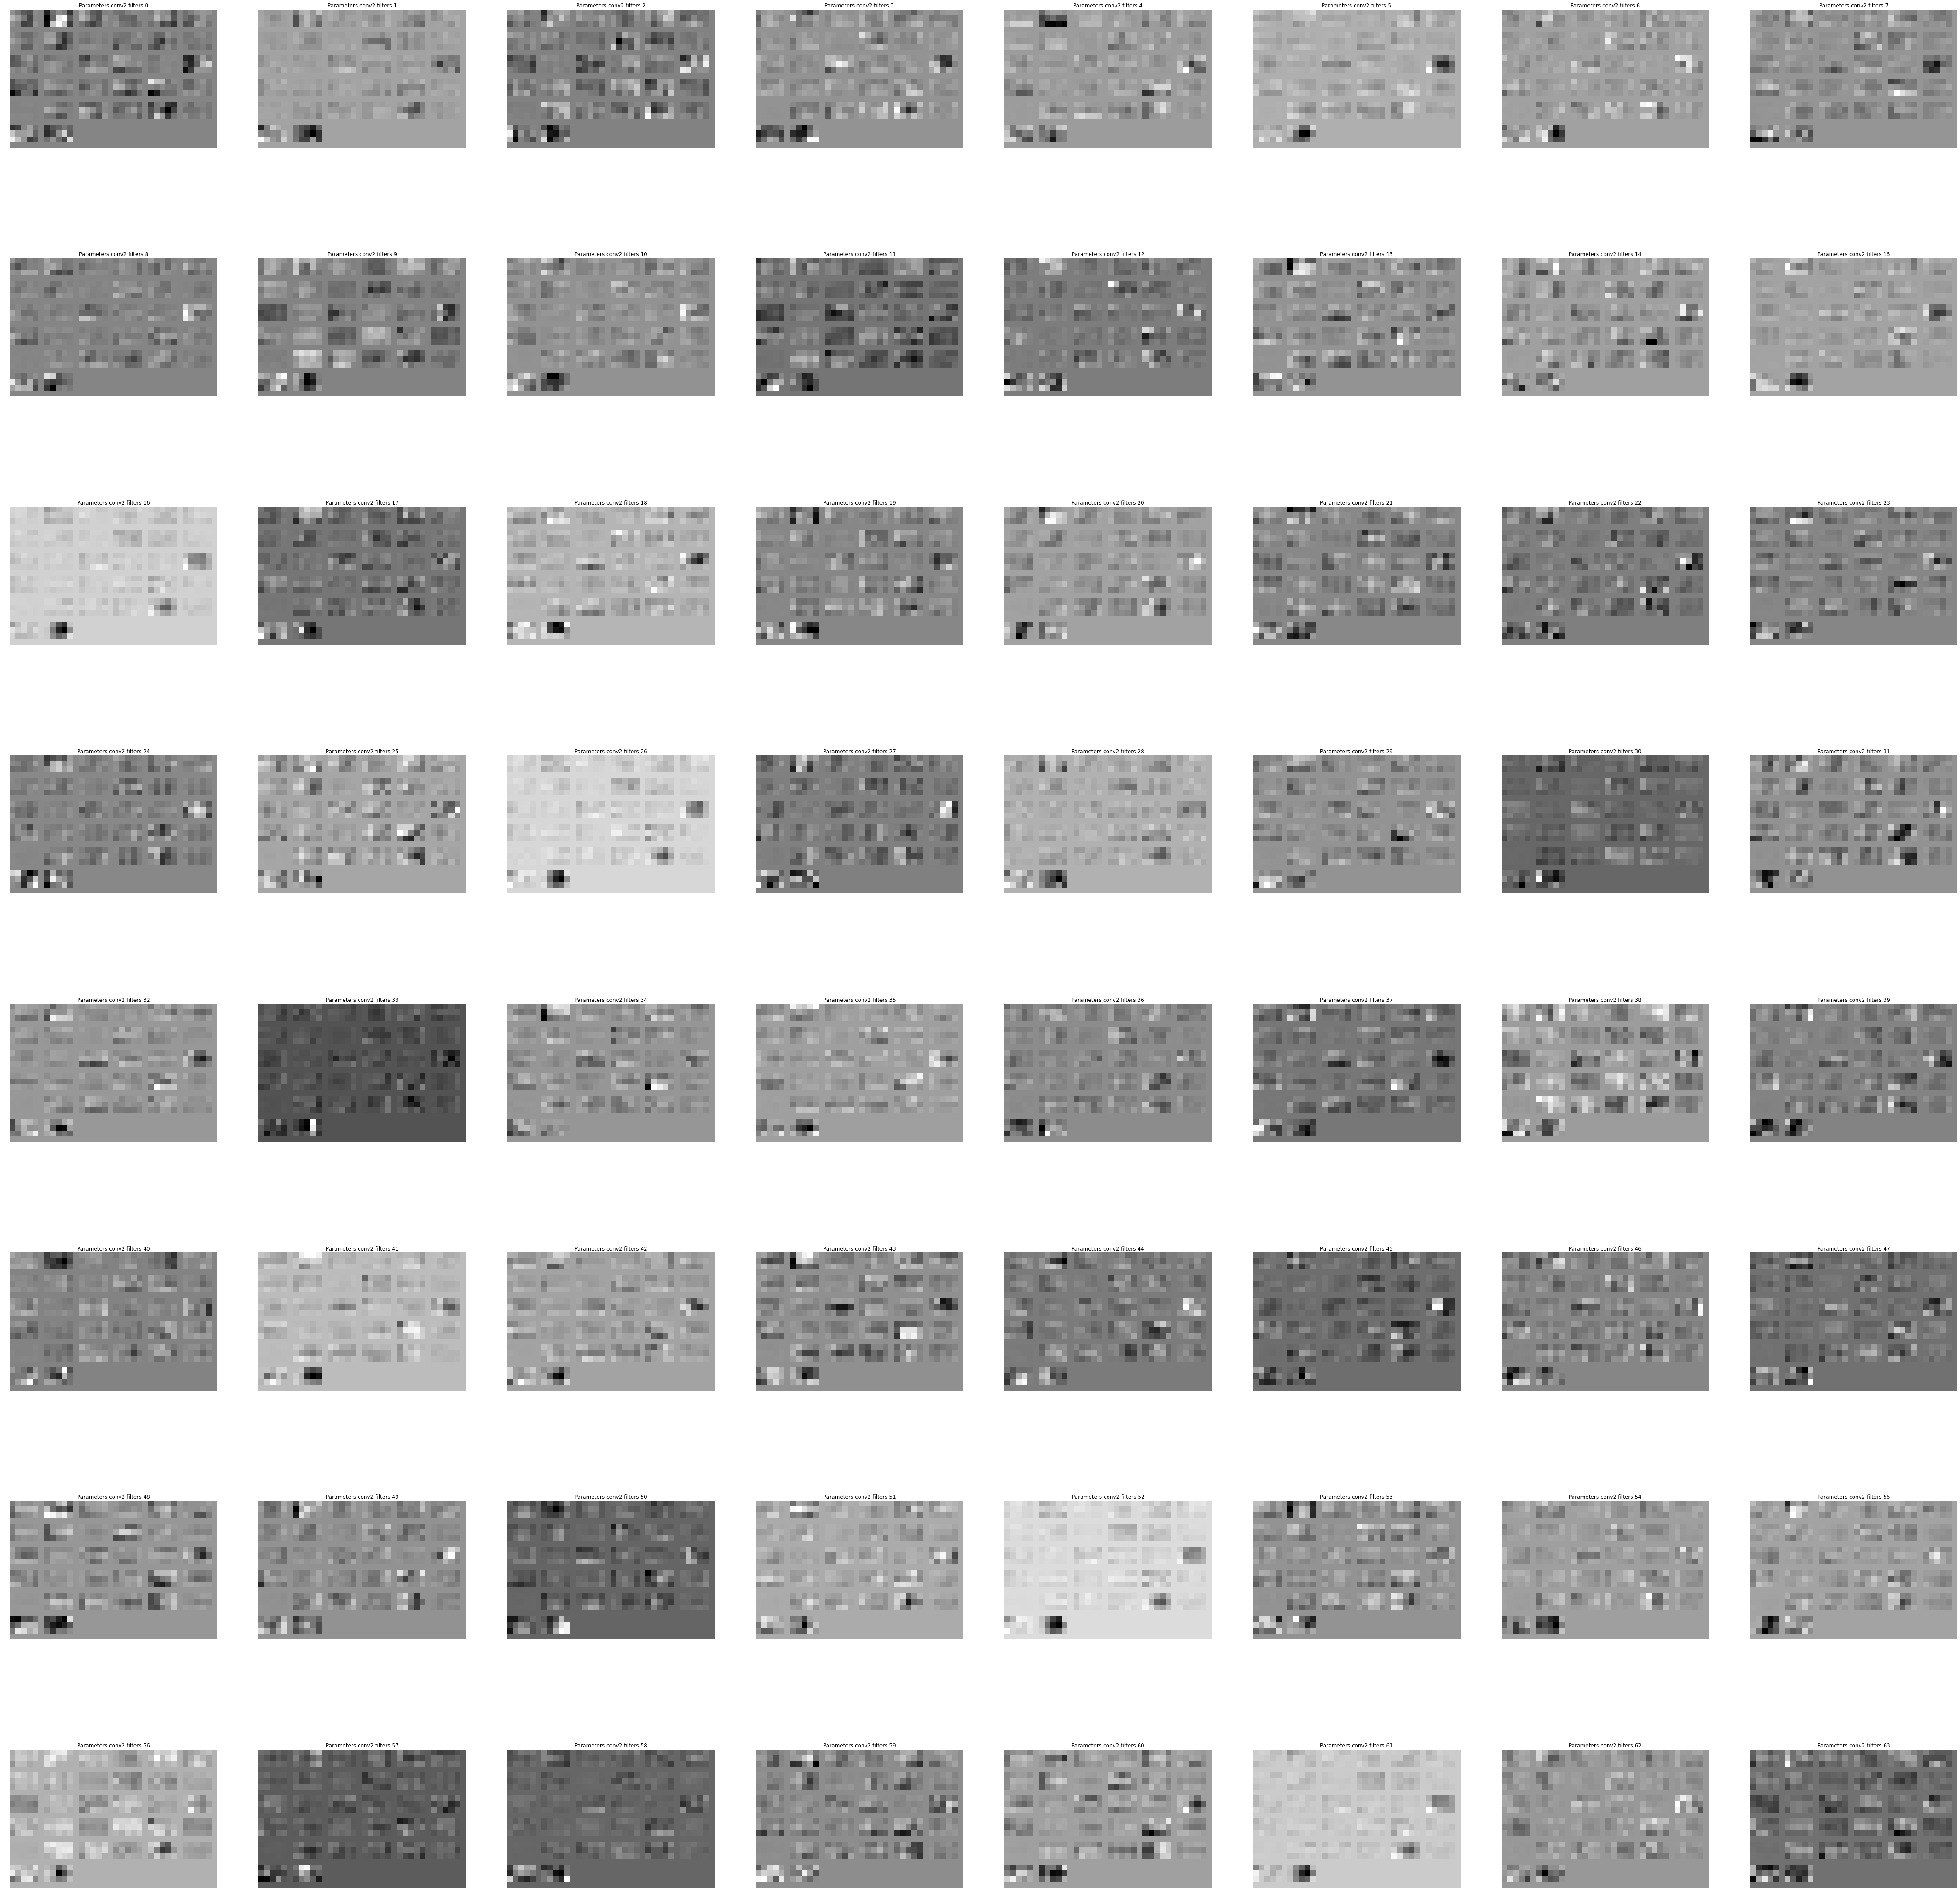

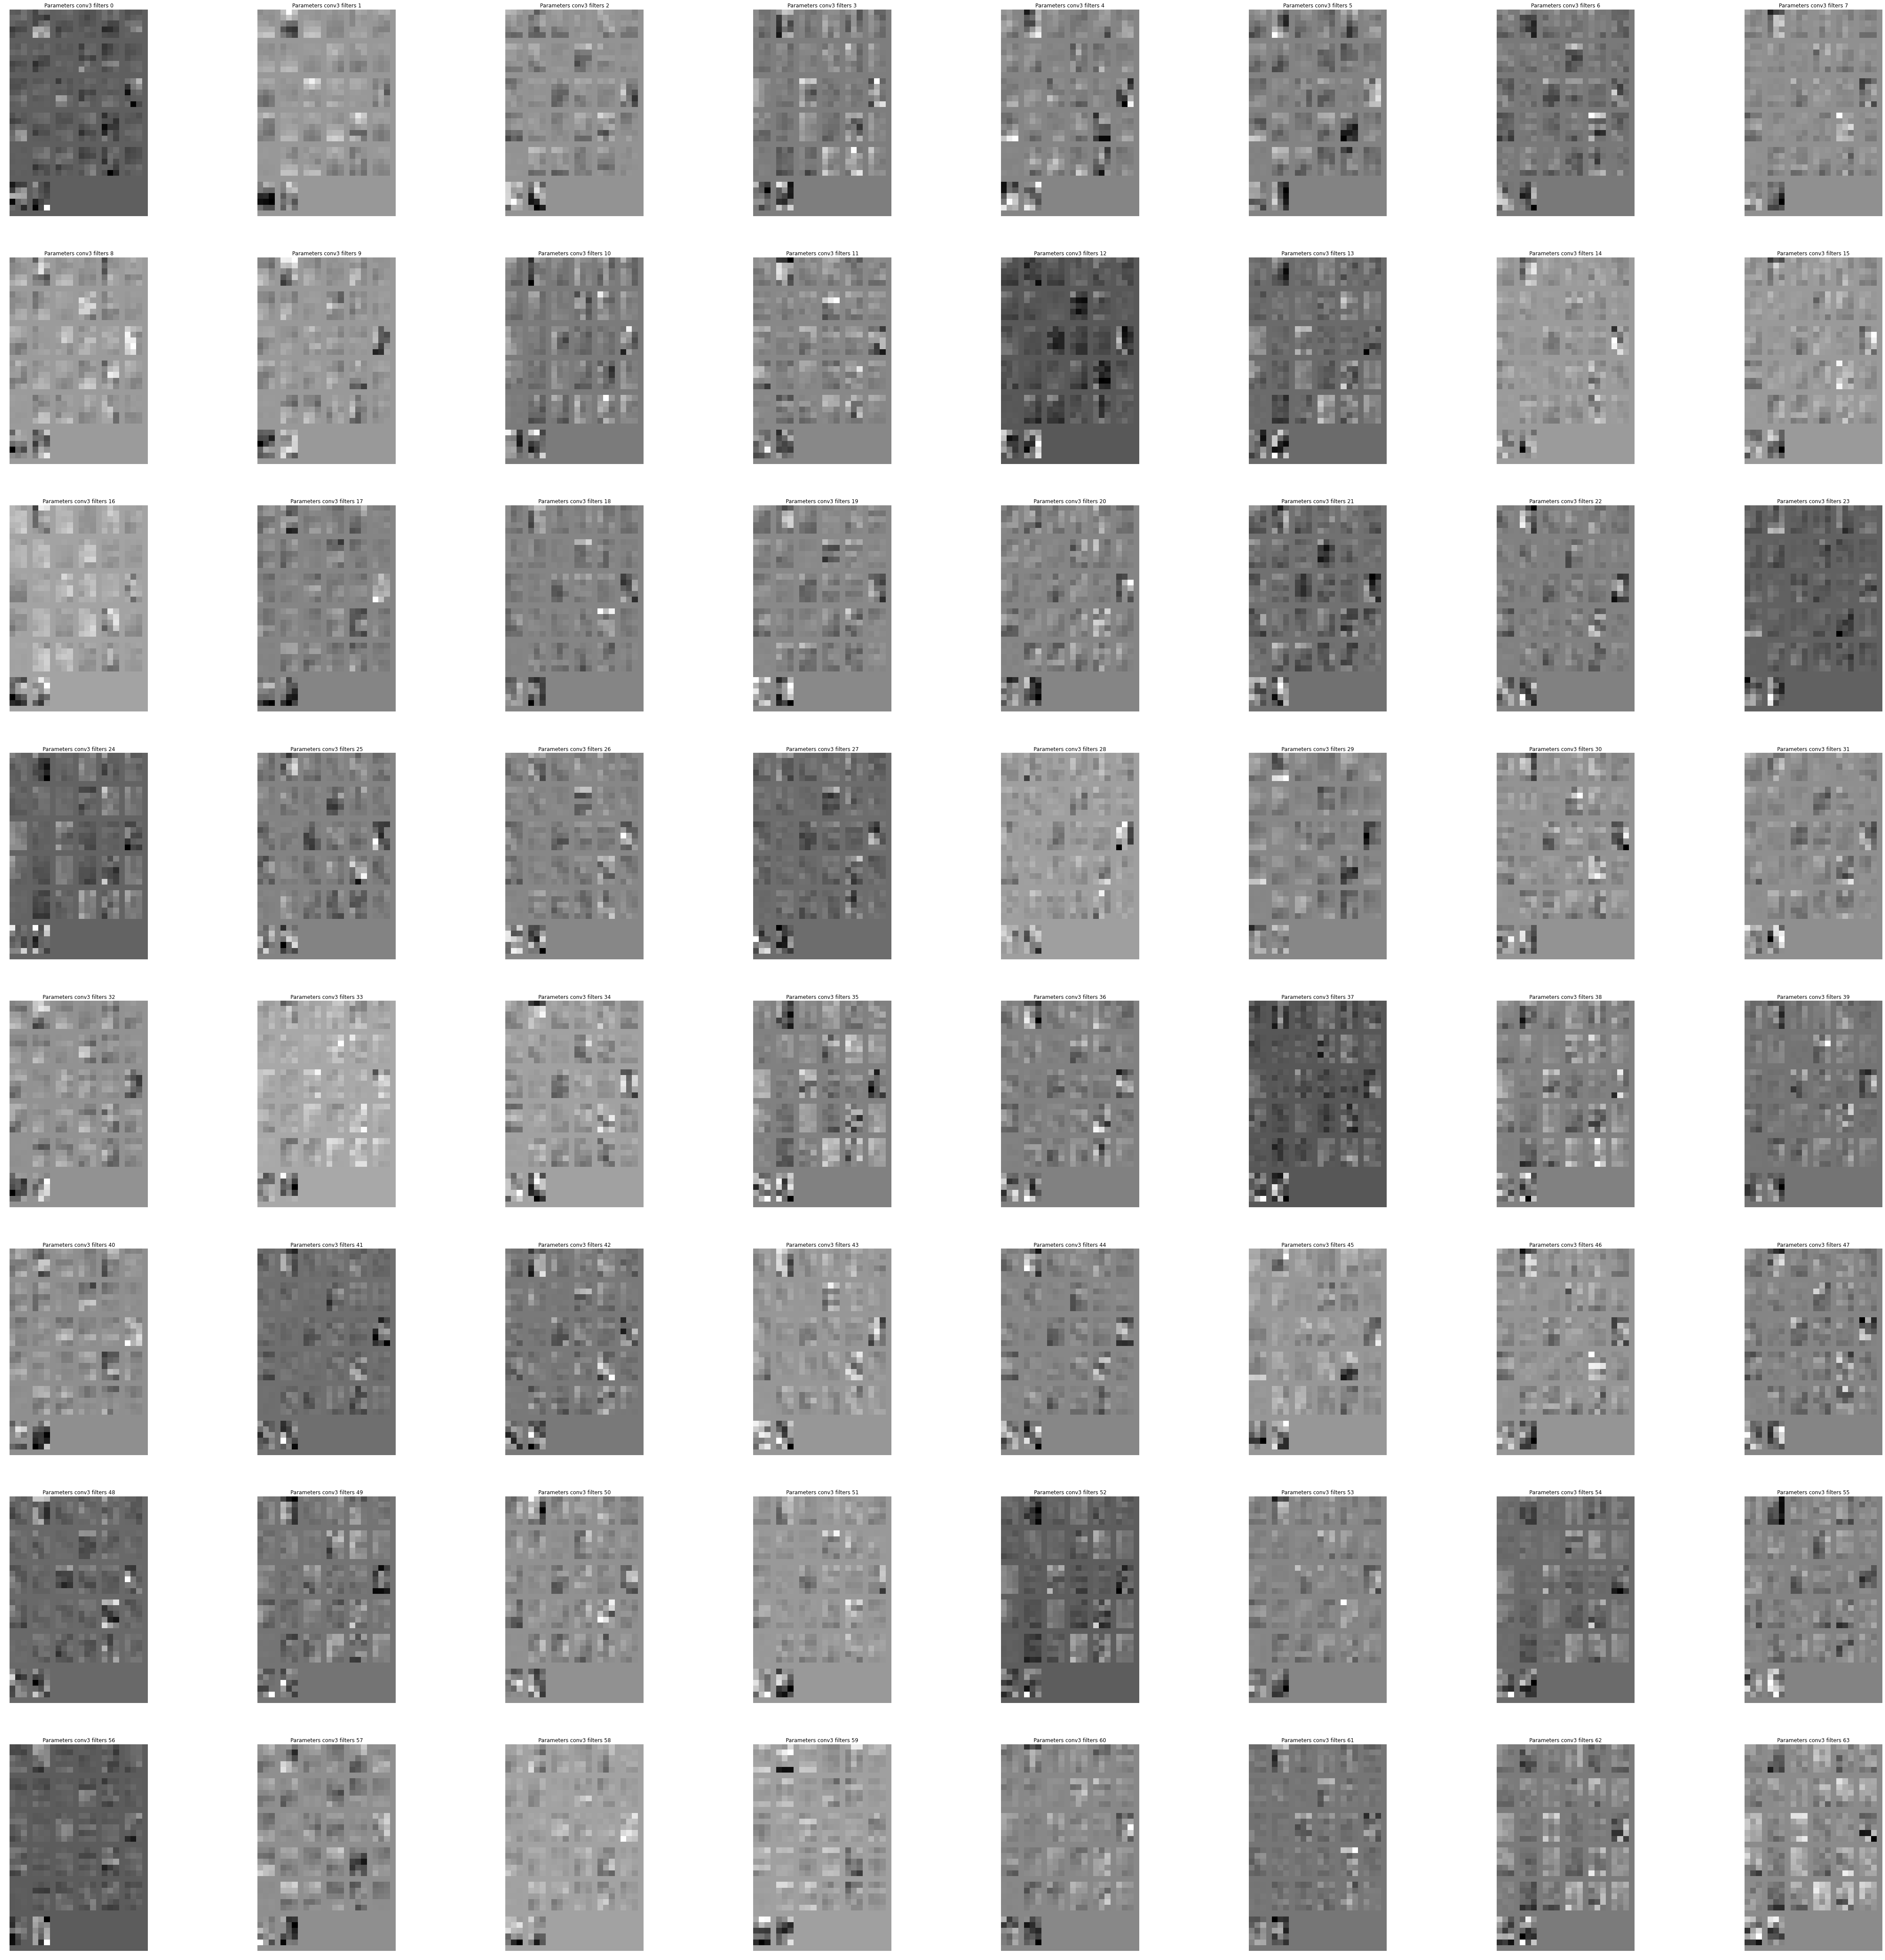

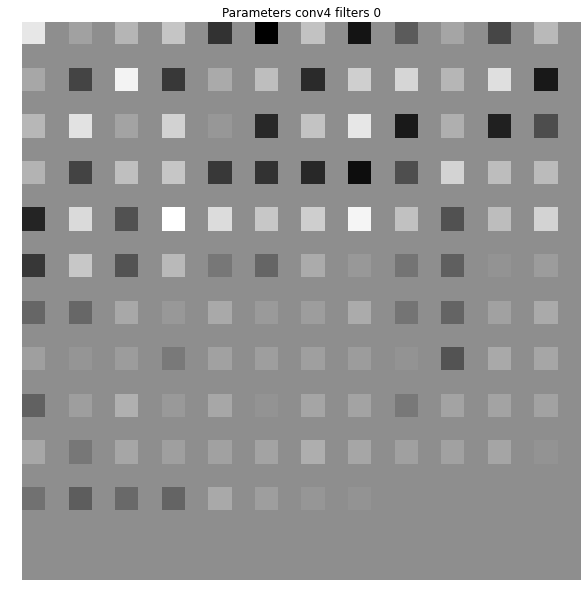

In [7]:
for layer_name in net.params.keys():
    layer = net.layers[layer_map[layer_name]]

    if layer.type == 'Convolution':
        n_kernels = net.params[layer_name][0].data.shape[0]
        height = ceil(np.sqrt(n_kernels))
        figure_size = (x * height for x in plt.rcParams['figure.figsize'])
        fig = plt.figure(figsize = figure_size)
        # fig.patch.set_color("white")
        
        for i in range(n_kernels):
            plt.subplot(height, height, i + 1)
            vis_square(net.params[layer_name][0].data[i])
            
            plt.title('Parameters {} filters {}'.format(layer_name, i))
            plt.axis('off')

## Forward
Now we can give the image as an input, and forward propagate it trough all the network. Then we can retrieve the hidden activations at each layer

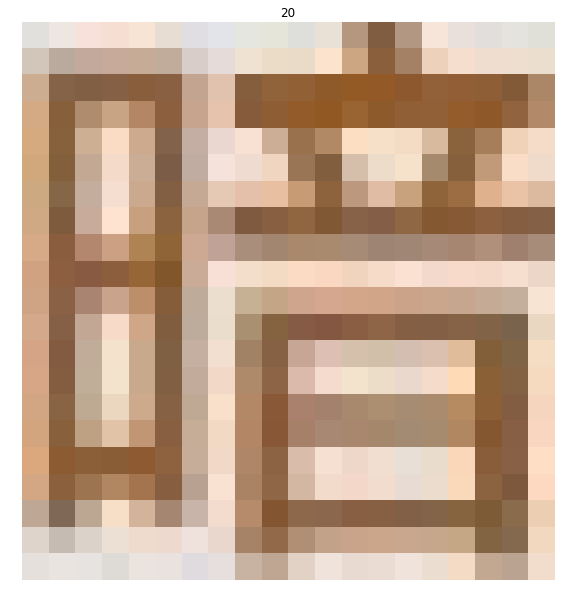

In [43]:
import os
import PIL.Image as Image

data_path = caffe_root + 'examples/images/'
im_names = ['20']
im_filenames = [os.path.join(data_path, name + ".jpg") for name in im_names]

images = [np.array(Image.open(im_filename)) for im_filename in im_filenames]

n_images = len(im_names)
figure_size = (n_images * plt.rcParams['figure.figsize'][0], 
               plt.rcParams['figure.figsize'][1])

fig = plt.figure(figsize = figure_size)

for i, (image, title) in enumerate(zip(images, im_names)):
    plt.subplot(1, n_images, i + 1)
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')



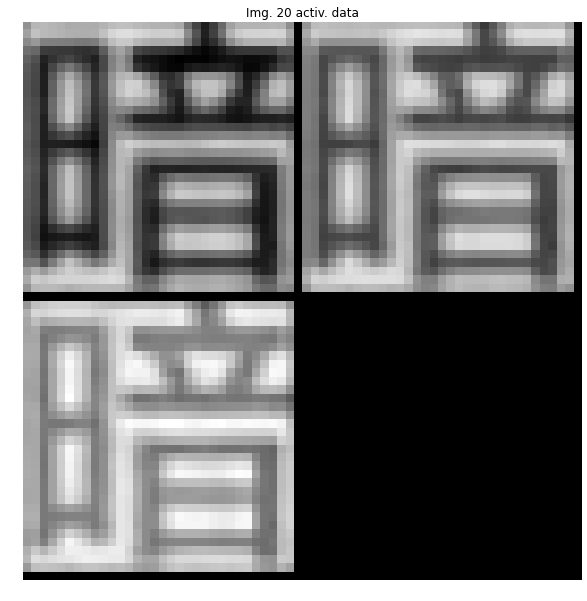

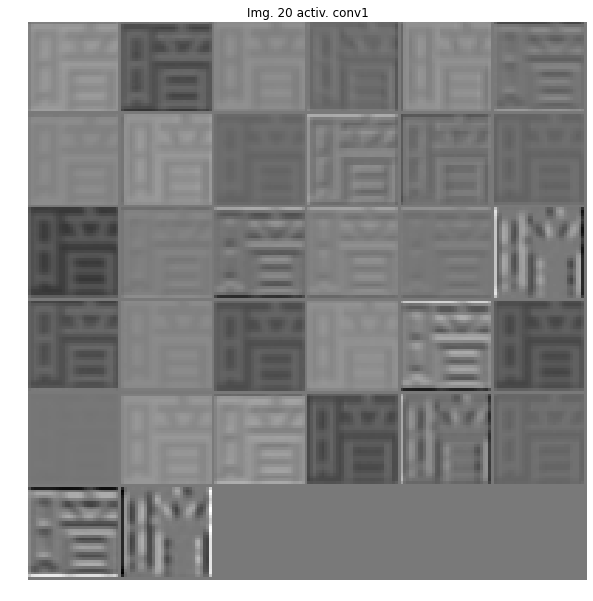

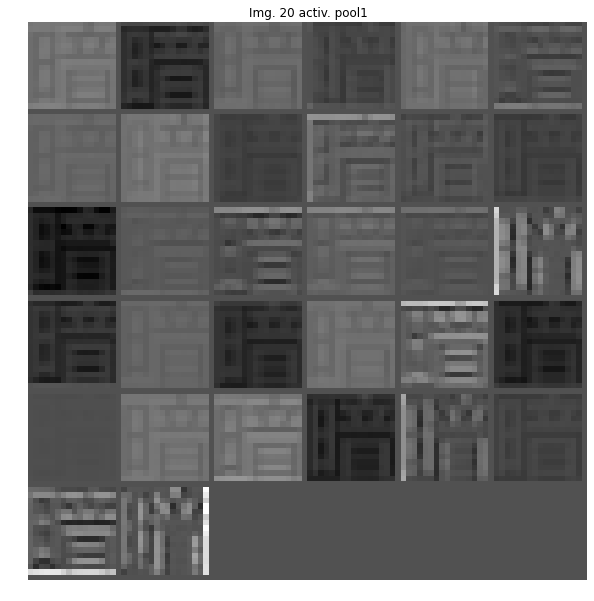

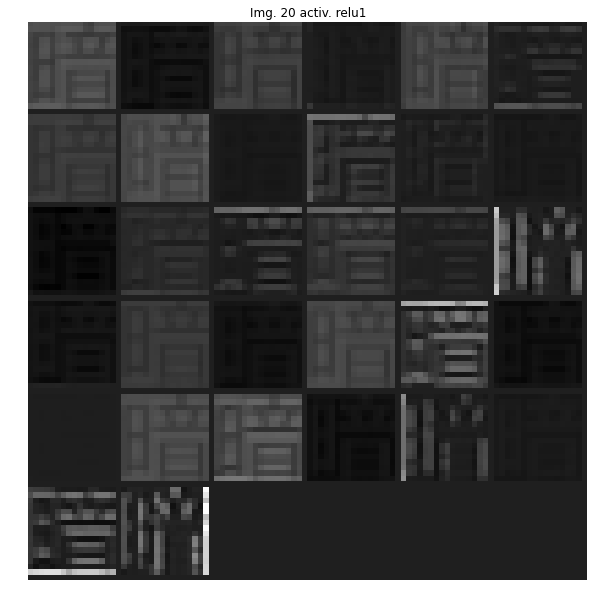

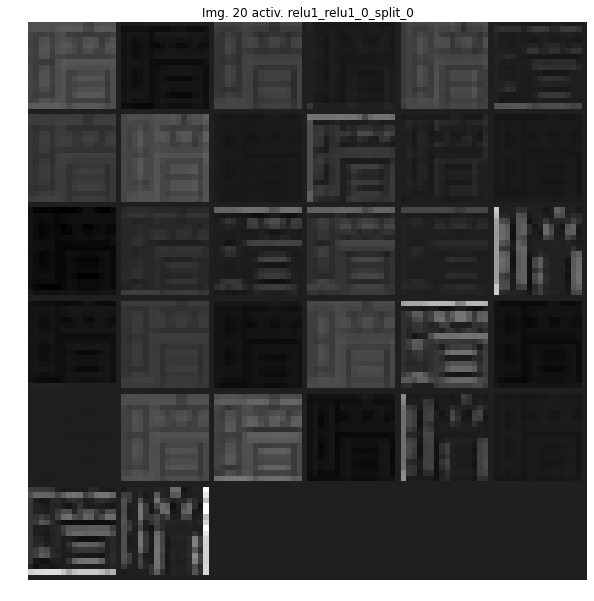

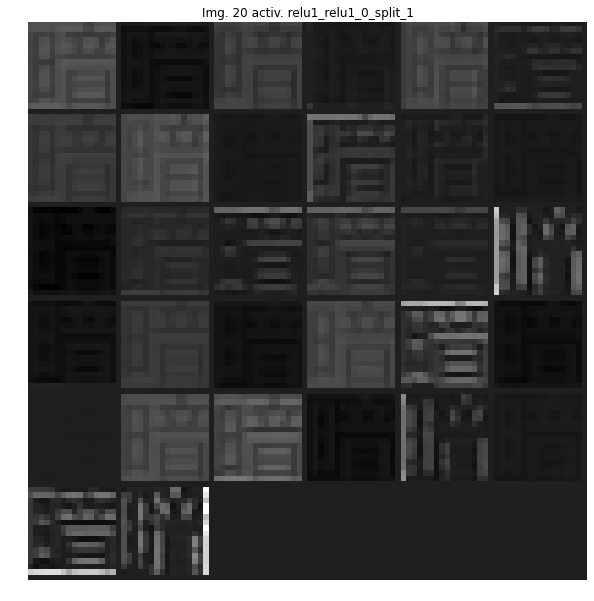

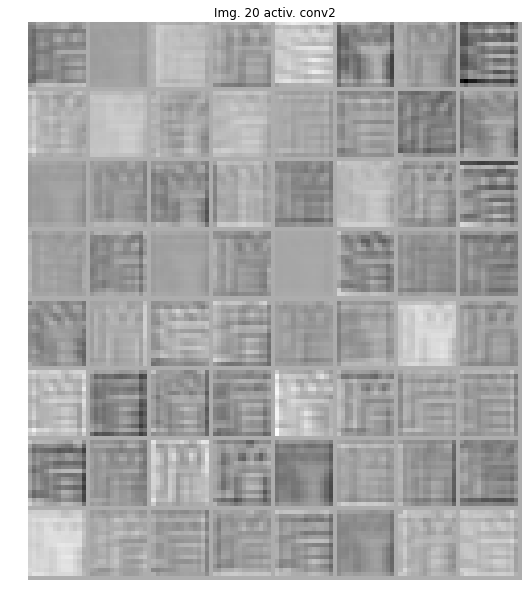

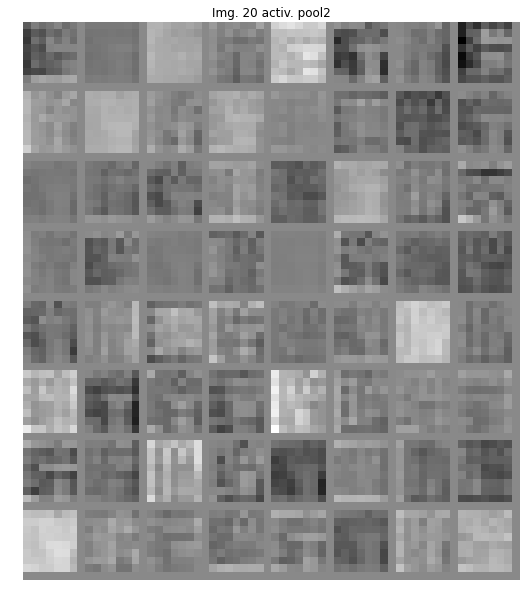

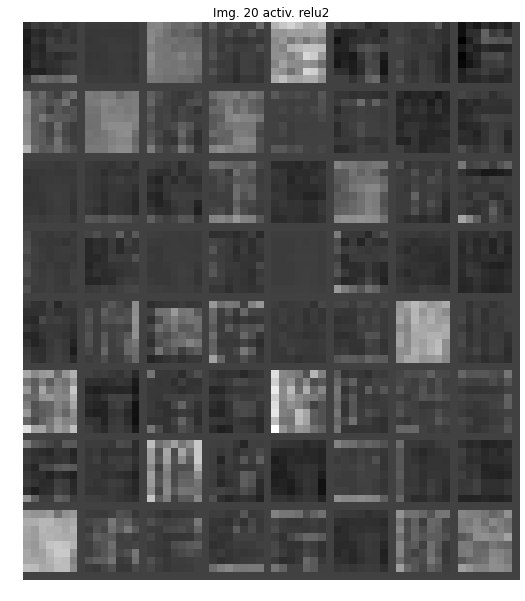

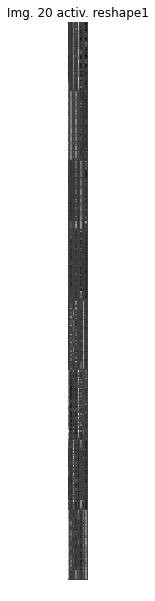

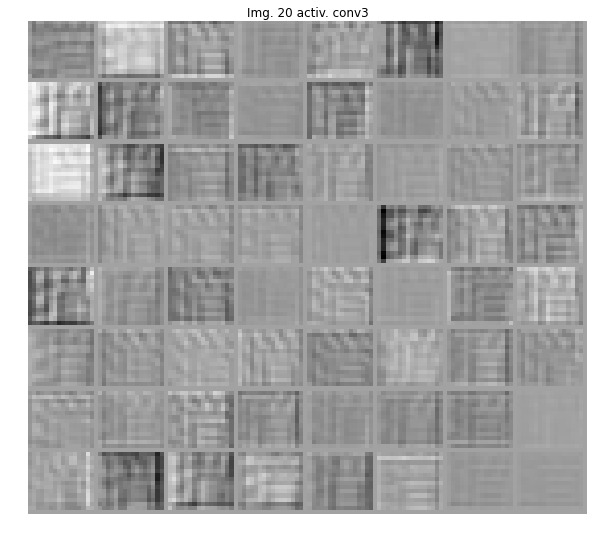

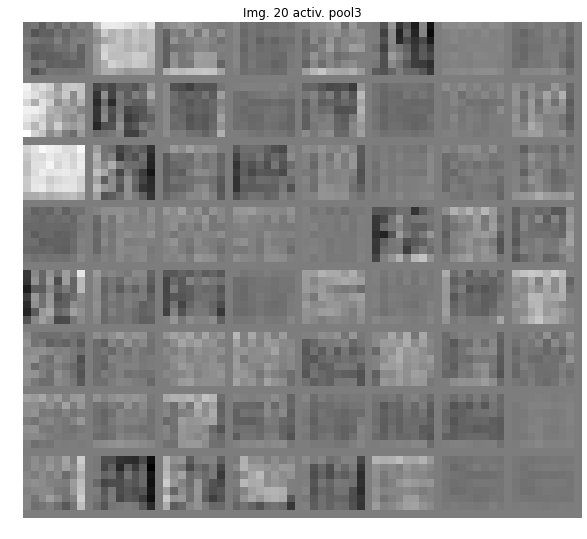

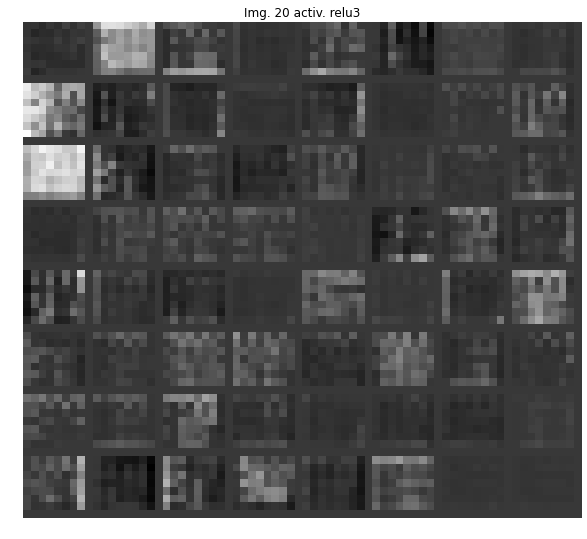

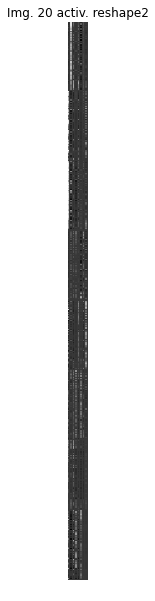

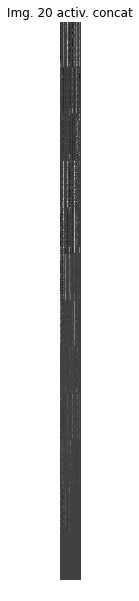

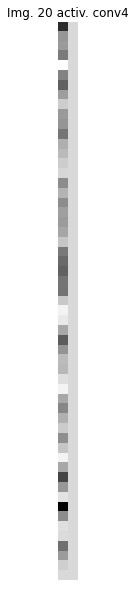

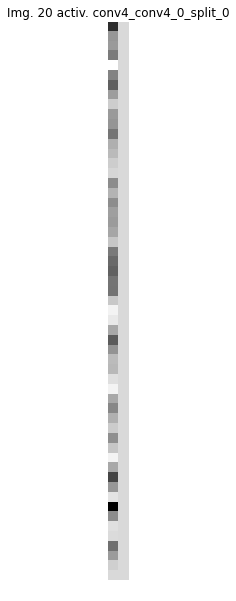

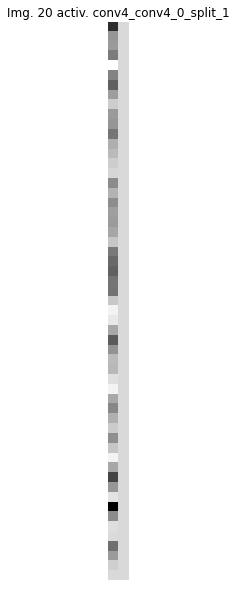

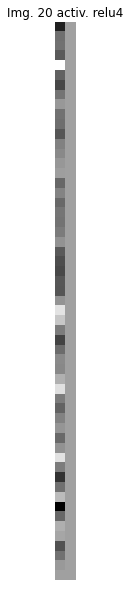

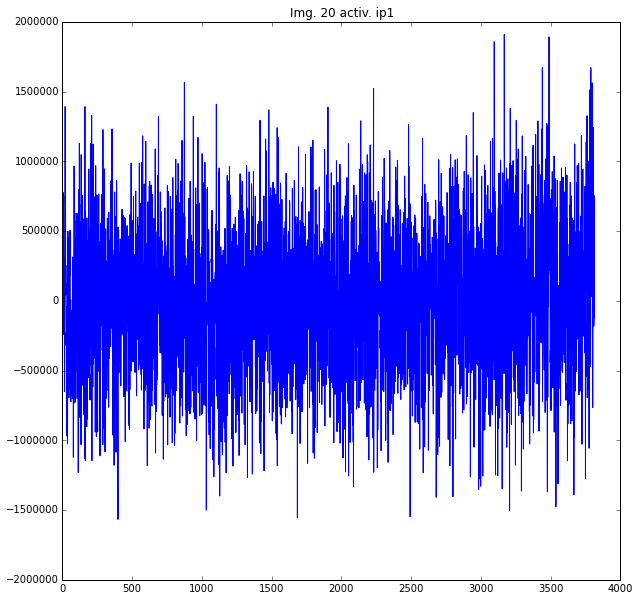

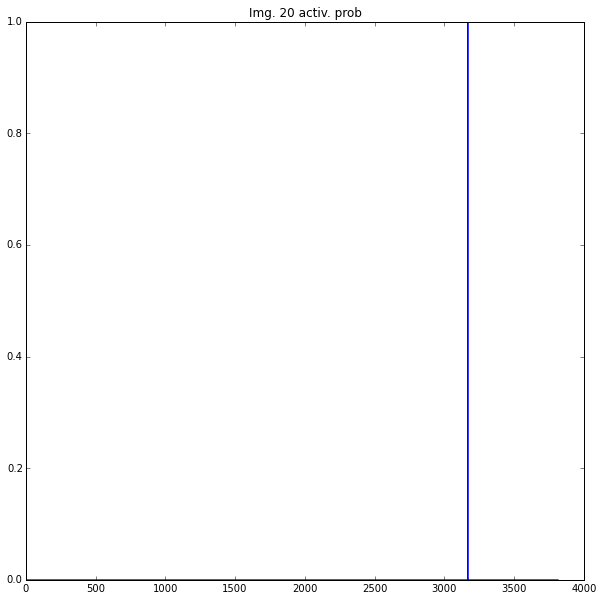

In [44]:
from collections import OrderedDict

def get_hidden_activations(net, image):
    im_input = image[np.newaxis, np.newaxis, :, :]
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    return OrderedDict([(name, np.copy(net.blobs[name].data)) for name in net.blobs.keys()])

hidden_activations = [get_hidden_activations(net, img) for img in images]

n_images = len(im_names)
figure_size = (n_images * plt.rcParams['figure.figsize'][0], 
               plt.rcParams['figure.figsize'][1])

for layer in net.blobs.keys():
    fig = plt.figure(figsize = figure_size)
    for i, title in enumerate(im_names):
        plt.subplot(1, n_images, i + 1)
        
        if len(hidden_activations[i][layer].shape) > 2:
            vis_square(hidden_activations[i][layer][0,:])
        else:
            plt.plot(hidden_activations[i][layer].flatten())
        plt.title('Img. {} activ. {}'.format(title, layer))
    filename = layer + '_comparison_activations'

## Comparing the hidden representations

In [45]:
distances = np.zeros((len(net.blobs.keys()),n_images,n_images))

for i, layer in enumerate(net.blobs.keys()):
    for j in range(n_images):
        for k in range(n_images):
            # Euclidean norm: Frobenius norm 
            distances[i,j,k] = np.linalg.norm((hidden_activations[j][layer] 
                                               - hidden_activations[k][layer]))
            
fig = plt.figure(figsize=(6,3.5))
plt.plot(distances[:-1,0,1]+1, label="{} vs {}".format(im_names[0], im_names[1]))
#ax.plot(distances[:-2,0,2]+1, label="{} vs {}".format(im_names[0], im_names[2]))
plt.plot(distances[:-1,1,2]+1, label="{} vs {}".format(im_names[1], im_names[2]))
plt.xticks(range(len(net.blobs.keys()[:-1])),net.blobs.keys()[:-1])
plt.legend(loc=1)
plt.xlabel("Layer")
plt.ylabel("Euclidean distance")
plt.title("Comparison of distances")
export_plot(fig,filename='comparison_distances',path=export_path,date=False)

IndexError: index 1 is out of bounds for axis 2 with size 1

## Backpropagation
It should be possible to backpropagate the error from the last layer by computing the cross-entropy error on the soft-max layer. However, it is also possible to visualize the gradient at each layer that maximize one specific neuron $i$ of the network. As an example, we can look at the most active neuron $i$ of the second convolution and introduce as an error zero for all the neurons that we do not want to maximize, 
and the neuron $i$ that we want to maximize to its double.

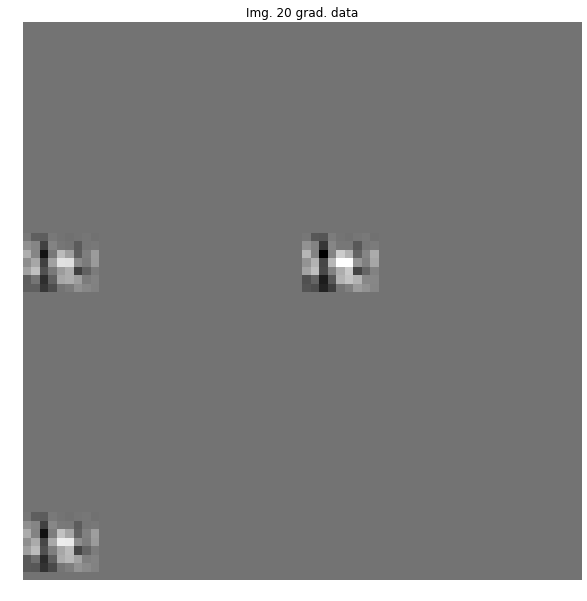

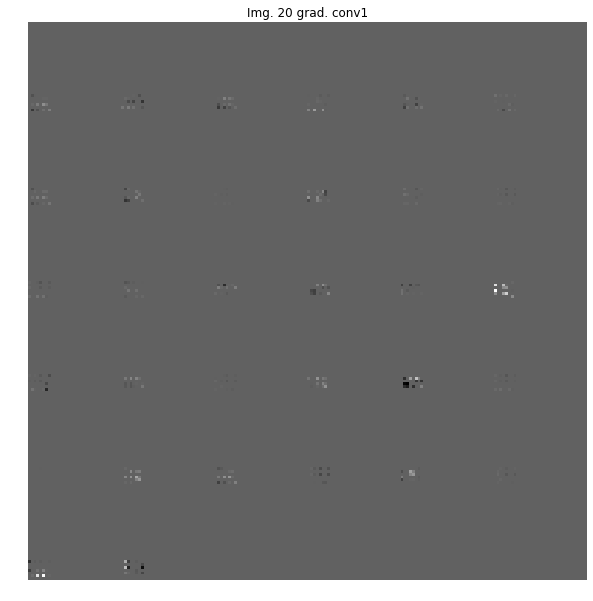

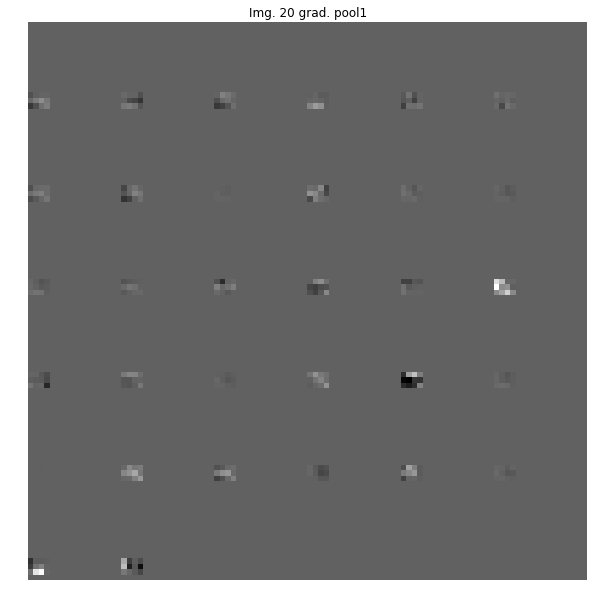

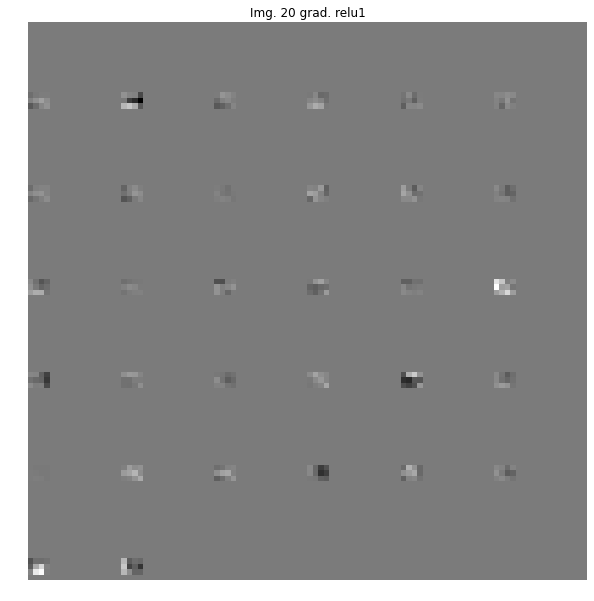

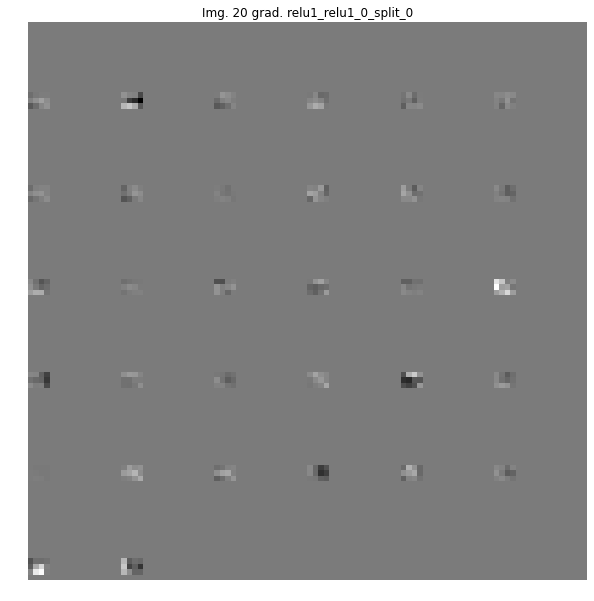

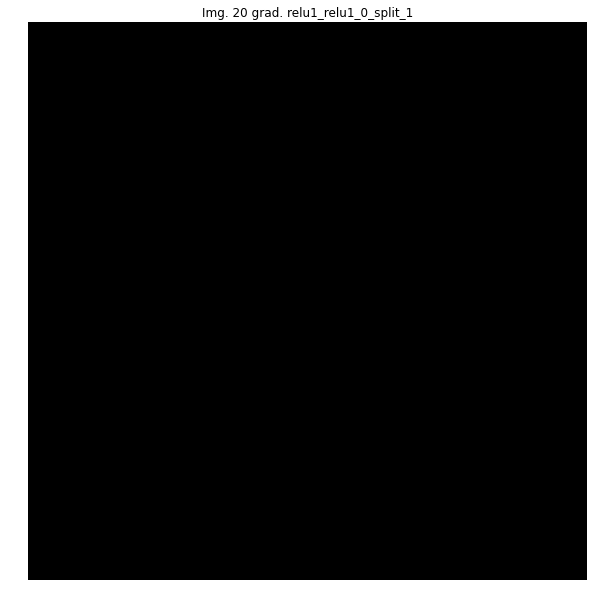

In [46]:
from collections import OrderedDict


def get_backward_gradients(net, image, end, neuron_coordinates = None, most_active = False):
    dst = net.blobs[end]

    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    
    net.forward(end = end)

    if neuron_coordinates:
        diff = np.zeros_like(dst.data)
        diff[neuron_coordinates] = 1
    elif most_active:
        neuron_coordinates = np.unravel_index(net.blobs[end].data.argmax(), net.blobs[end].data.shape)
        diff = np.zeros_like(dst.data)
        diff[neuron_coordinates] = 1
    else:
        diff = dst.data
        
    dst.diff[:] = diff
    net.backward(start = end)

    gradients = OrderedDict()
    for layer in net.blobs.keys():
        if layer != end:
            gradients.update({layer : np.copy(net.blobs[layer].diff[0])})
        else:
            break
    return gradients

end = 'conv2'
most_active = True
gradients = [get_backward_gradients(net, image, end = end, most_active = most_active) for image in images]

n_images = len(im_names)
figure_size = (n_images * plt.rcParams['figure.figsize'][0],  plt.rcParams['figure.figsize'][1])

for layer in gradients[0].keys():
    fig = plt.figure(figsize = figure_size)
    for i, title in enumerate(im_names):
        plt.subplot(1, n_images, i + 1)
        vis_square(gradients[i][layer])
        plt.title('Img. {} grad. {}'.format(title, layer))

It is also possible to give as an error for a layer exactly the same activation. With this idea we tell to the network that whatever the network creates, we want to maximize it. Then we can visualize the gradients in all the previous layers up to the input image

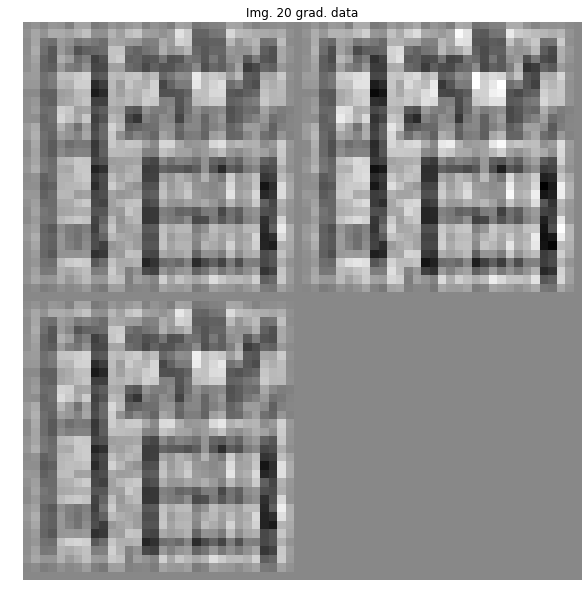

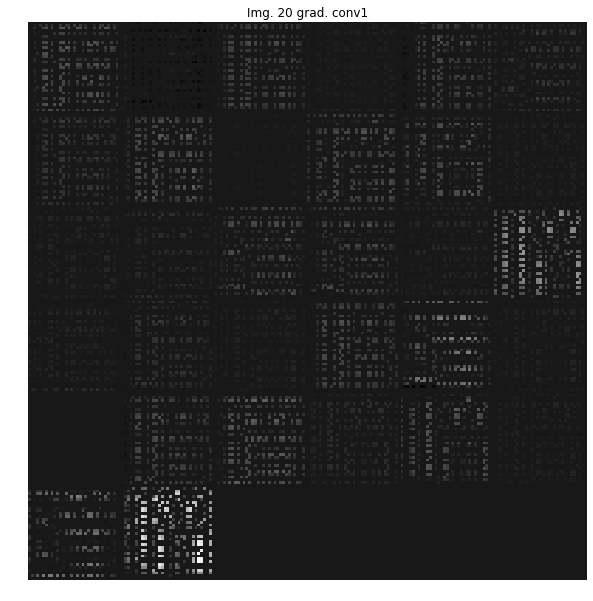

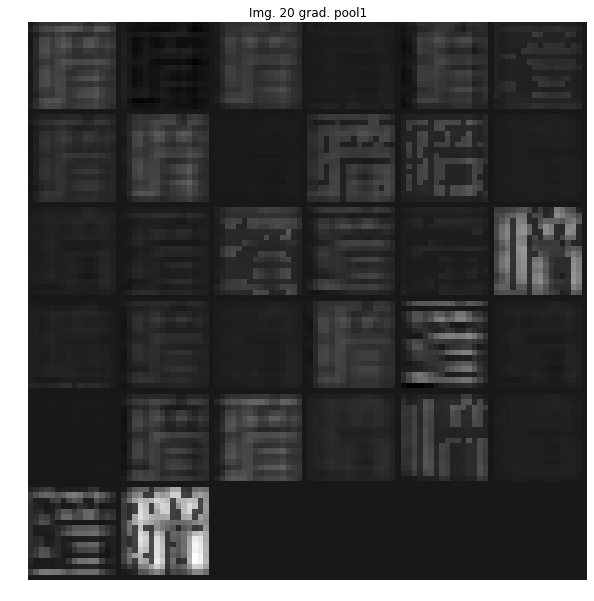

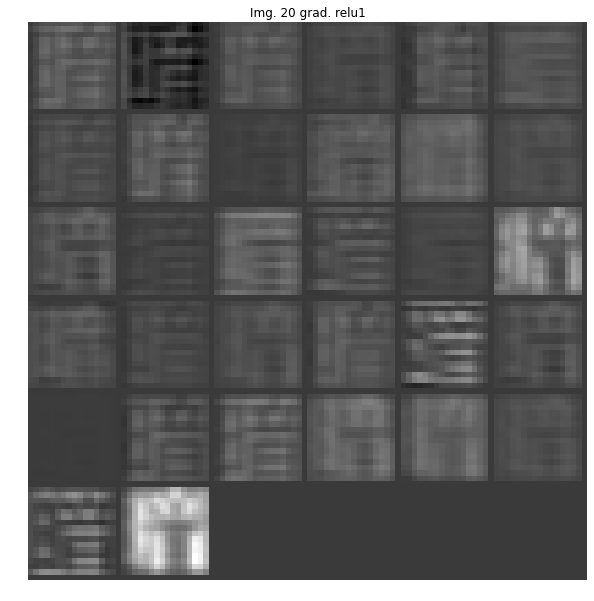

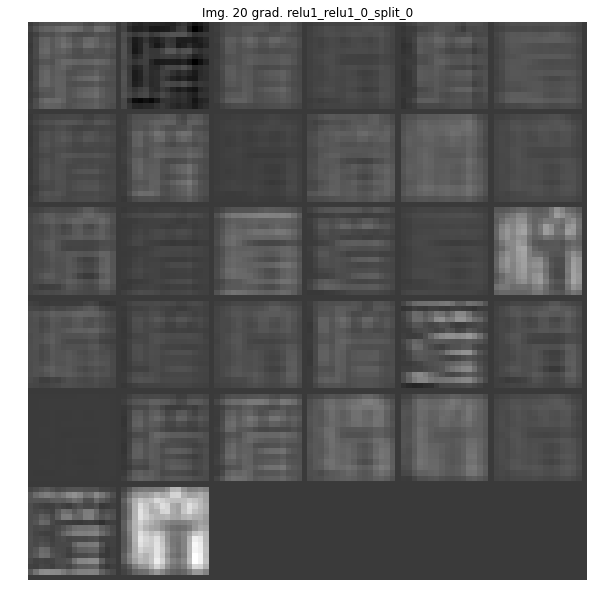

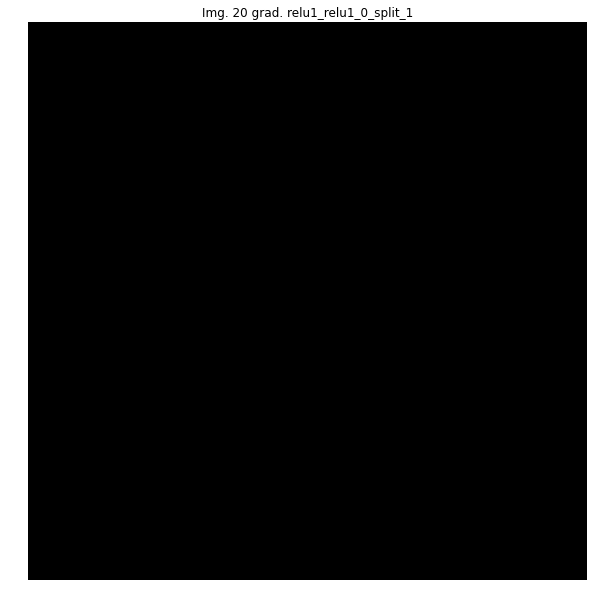

In [47]:
end = 'conv2'
most_active = False
gradients = [get_backward_gradients(net, image, end=end, most_active = most_active) for image in images]

n_images = len(im_names)
figure_size = (n_images * plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1])

for layer in gradients[0].keys():
    fig = plt.figure(figsize = figure_size)
    for i, title in enumerate(im_names):
        plt.subplot(1, n_images, i + 1)
        vis_square(gradients[i][layer])
        plt.title('Img. {} grad. {}'.format(title, layer))
    filename = layer + '_comparison_gradients'